# Dog Breeds Image Classification

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
INSTALL_PACKAGES = False
if INSTALL_PACKAGES:
    !pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os

BUCKET = 'project03-image-classification-vexenta'

## Dataset

*TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.*

The dataset contains images of 133 dog breeds, which are already split into train, validation, and test sets.

In [41]:
#TODO: Fetch and upload the data to AWS S3
DOWNLOAD_DATASET = False
if DOWNLOAD_DATASET:
    # Command to download and unzip data
    !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
    !unzip dogImages.zip
    
UPLOAD_TO_S3 = False
os.environ["DEFAULT_S3_BUCKET"] = BUCKET

if UPLOAD_TO_S3:
    !aws s3 sync ./dogImages/train s3://${DEFAULT_S3_BUCKET}/data/train/
    !aws s3 sync ./dogImages/valid s3://${DEFAULT_S3_BUCKET}/data/valid/
    !aws s3 sync ./dogImages/test s3://${DEFAULT_S3_BUCKET}/data/test/

There are 133 dog breeds; each dog breed image is stored in a directory. There are at least 20 images per breed.

In [49]:
## ensure the files are successfully uploaded
CHECK_UPLOAD = True
if CHECK_UPLOAD:
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/  | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/valid/ | wc -l
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/test/ | wc -l
        
    ## preview of the breeds
    !aws s3 ls s3://${DEFAULT_S3_BUCKET}/data/train/ | tail -n 10

133
133
133
                           PRE 124.Poodle/
                           PRE 125.Portuguese_water_dog/
                           PRE 126.Saint_bernard/
                           PRE 127.Silky_terrier/
                           PRE 128.Smooth_fox_terrier/
                           PRE 129.Tibetan_mastiff/
                           PRE 130.Welsh_springer_spaniel/
                           PRE 131.Wirehaired_pointing_griffon/
                           PRE 132.Xoloitzcuintli/
                           PRE 133.Yorkshire_terrier/


### Dataset Preview

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def show_image(image_file_directory: str = None, image_file_path: str = None):
    if image_file_path is None:
        assert image_file_directory is not None, "image_file_directory must be specified if image_file_path is None!"
        image_file_name_list = os.listdir(image_file_directory)
        selected_image_index = np.random.choice(len(image_file_name_list))
        selected_image_file_name = image_file_name_list[selected_image_index]
        image_file_path = os.path.join(
            image_file_directory,
            selected_image_file_name
        )
    else:
        selected_image_file_name = image_file_path.split("/")[-1]
    
    img = mpimg.imread(image_file_path)
    img_plot = plt.imshow(img)
    plt.title(selected_image_file_name)
    plt.show()

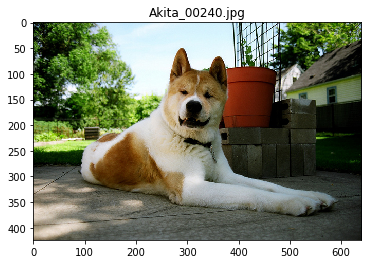

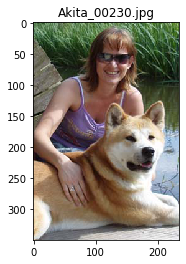

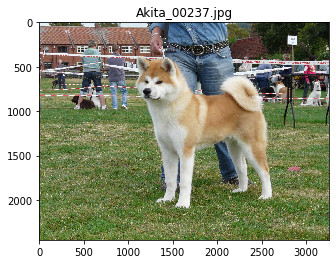

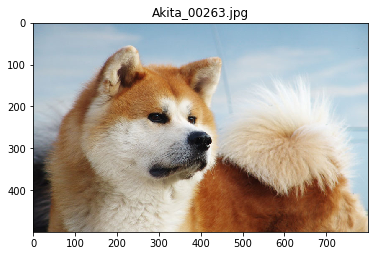

In [44]:
show_image(image_file_directory="dogImages/train/004.Akita")
show_image(image_file_path="dogImages/train/004.Akita/Akita_00230.jpg")

show_image(image_file_directory="dogImages/valid/004.Akita")
show_image(image_file_directory="dogImages/test/004.Akita")

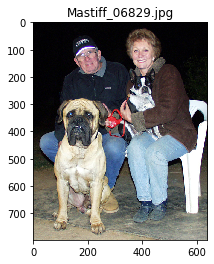

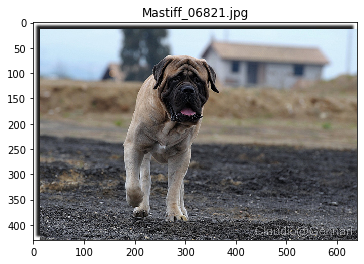

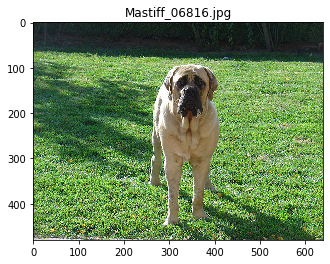

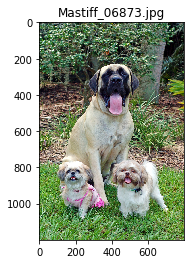

In [45]:
show_image(image_file_directory="dogImages/train/103.Mastiff")
show_image(image_file_path="dogImages/train/103.Mastiff/Mastiff_06821.jpg")

show_image(image_file_directory="dogImages/valid/103.Mastiff")
show_image(image_file_directory="dogImages/test/103.Mastiff")

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a **minimum of two hyperparameters**. However you are encouraged to tune more. You are also encouraged to explain **why** you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [ ]:
#TODO: Declare your HP ranges, metrics etc.

In [ ]:
#TODO: Create estimators for your HPs

estimator = # TODO: Your estimator here

tuner = # TODO: Your HP tuner here

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit() # TODO: Remember to include your data channels

In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

estimator = # TODO: Your estimator here

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()